<a href="https://colab.research.google.com/github/jmarrietar/ocular/blob/master/notebooks/Fully_supervised_embeddings_TSNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
#GPU count and name
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-5dcf98f3-f29d-ddcb-224e-1cefde455f56)


In [9]:
# Mount Drive
from google.colab import drive
from google.colab import auth
from googleapiclient.http import MediaFileUpload
from googleapiclient.discovery import build

In [10]:
auth.authenticate_user()
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import os
import zipfile
import itertools
import numpy as np
import h5py
import random
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from mlxtend.plotting import plot_confusion_matrix 
%matplotlib inline

import tensorflow as tf

import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model, model_from_json
from keras_preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

print(f"Numpy version: {np.__version__}")
print(f"Tensorflow version: {tf.__version__}")

random.seed(432)

Numpy version: 1.21.5
Tensorflow version: 2.8.0


In [12]:
# Parameters 
BATCH_SIZE = 32
num_workers = 8
num_epochs = 200
learning_rate = 1e-6
decay = 4e-5
min_delta_auc = 0.01
BATCH_SIZE = 32
img_width, img_height = 299, 299

In [13]:
!gdown https://drive.google.com/uc?id=1HaUAxDtN4BNj0hpH8QYGmiX39Va-Ke8p

Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1HaUAxDtN4BNj0hpH8QYGmiX39Va-Ke8p 



In [14]:
local_zip = '/content/messidor2.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [15]:
TEST_MESSIDOR_DIR = "/content/messidor2"

In [16]:
batch_size = 32

messidor_datagen = ImageDataGenerator(samplewise_center = True, 
                                      rescale=1./255)

messidor_generator = messidor_datagen.flow_from_directory(
	TEST_MESSIDOR_DIR,
    target_size=(img_width, img_height),
    color_mode='rgb',
	class_mode='binary', 
    batch_size=1,
    shuffle=False,
)

Found 1748 images belonging to 2 classes.


In [17]:
model_information = {
    "sample@1000": {
        "data": "https://drive.google.com/uc?id=1DPZrHrj3Bdte5Dc6NCZ33CAqMG-Oipa2",
        "JSON_STRUCTURE_FILE": "InceptionV3_warm_up_sample@1000.json",
        "WEIGHTS_FILE": "InceptionV3-sample@1000-epochs:043-val_loss:0.585.hdf5",
    }
}

In [20]:
SAMPLE = "sample@1000"

In [21]:
JSON_STRUCTURE_FILE = model_information[SAMPLE]["JSON_STRUCTURE_FILE"]
WEIGHTS_FILE = model_information[SAMPLE]["WEIGHTS_FILE"]

In [22]:
#with strategy.scope():
# Load json file structure and create model
json_file = open('drive/My Drive/Project/model/{}'.format(JSON_STRUCTURE_FILE), 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)

In [23]:
#with strategy.scope():
#Load weights into new model
model.load_weights('drive/My Drive/Project/model/{}'.format(WEIGHTS_FILE))
print("Loaded model from Drive")

Loaded model from Drive


In [24]:
for layer in model.layers:
    layer.trainable = False

# change the learning rate
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate,
                                       decay=decay),
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

In [27]:
#model.summary()

In [28]:
def create_plots(y_true, y_pred, y_pred_prob):
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred_prob, pos_label=1)
    cm=metrics.confusion_matrix(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_prob)
    print('AUC: %.3f' % auc)
    print('Accuracy: {}'.format(accuracy_score(y_true, y_pred)))

    # Plot ROC curve
    lw = 2
    sns.set_style({'axes.grid' : False})
    sns.set_style("darkgrid")
    ax1 = sns.lineplot(fpr, tpr, color='darkorange',
            lw=lw, label='AUC = %0.2f' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    ax1.set_title('Receiver operating characteristic')
    ax1.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    plt.legend(loc="lower right")
    plt.show()

    # Plot Confusion Matrix 
    fig, ax2 = plot_confusion_matrix(conf_mat=cm,
                                    show_normed=False)
    plt.show()

In [29]:
threshold = 0.5
y_true = messidor_generator.classes
y_pred_prob = model.predict(messidor_generator, verbose=1, workers=5)
y_pred_prob = np.hstack(y_pred_prob)
threshold = 0.5
y_pred = (y_pred_prob> threshold).astype('int')

1748/1748 [==============================] - 34s 15ms/step


In [30]:
threshold = 0.5
y_pred = (y_pred_prob> threshold).astype('int')

AUC: 0.658
Accuracy: 0.767162471395881


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


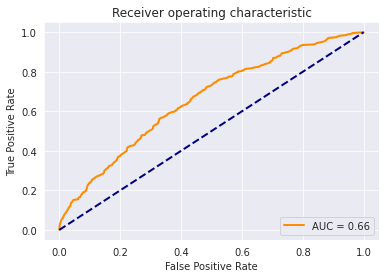

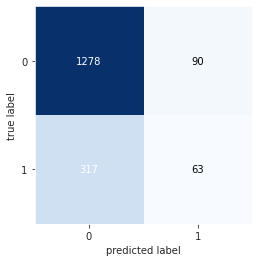

In [31]:
create_plots(y_true, y_pred, y_pred_prob)

In [36]:
#model.summary()

In [33]:
import keras

In [35]:
inter_output_model = keras.Model(model.input, model.get_layer("dense").output )

In [37]:
threshold = 0.5
y_true = messidor_generator.classes
representations = inter_output_model.predict(messidor_generator, verbose=1, workers=5)

1748/1748 [==============================] - 25s 13ms/step


In [39]:
representations.shape

(1748, 2048)

In [40]:
embeddings = representations

In [41]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
#import umap

def create_dataframe(y_pred_prob, y_true, dim_method):

    dimensionality_reduction = {
        "PCA": PCA(n_components=2),
        "TSNE": TSNE(n_components=2),
        #"UMAP": umap.UMAP(random_state=42),
    }

    method = dimensionality_reduction[dim_method]
    projected = method.fit_transform(y_pred_prob)
    dataset = pd.DataFrame(
        {"X": projected[:, 0], "Y": projected[:, 1], "class": y_true}
    )
    return dataset

In [42]:
ans = create_dataframe(embeddings, y_true, "TSNE")

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [44]:
%matplotlib inline
import seaborn as sns; sns.set()
sns.set(rc={'figure.figsize':(12,10)})

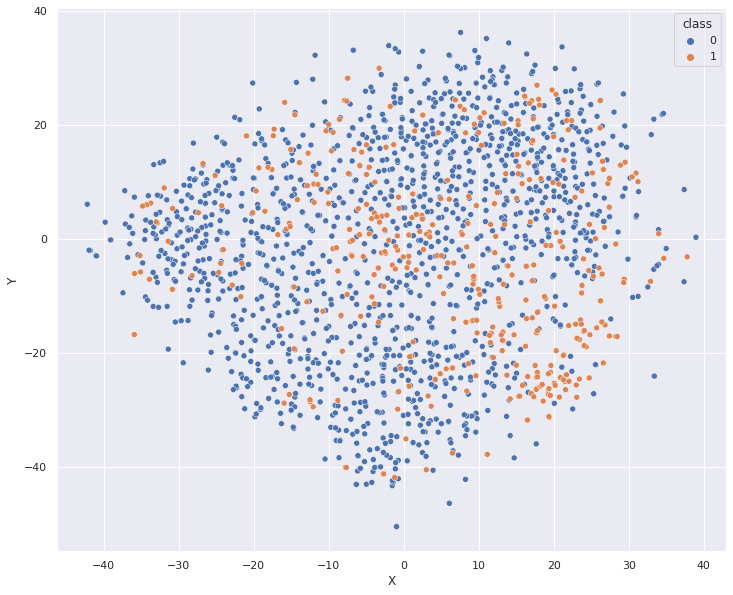

In [45]:
sns.scatterplot(data=ans, x="X", y="Y", hue="class")